Bulk driving behavior model trained and saved.
Model Accuracy: 1.0000


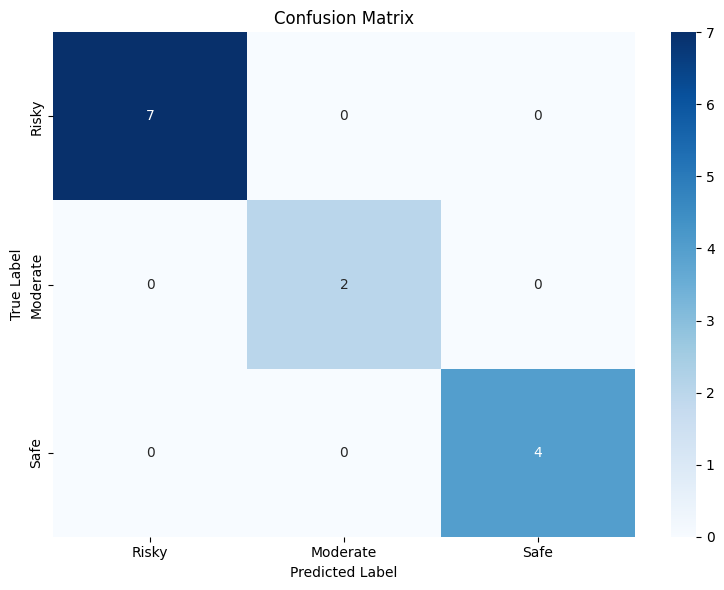

Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00         7
    Moderate       1.00      1.00      1.00         2
        Safe       1.00      1.00      1.00         4

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13

Cross-Validation Accuracy (5-fold): 0.9800 ± 0.0400


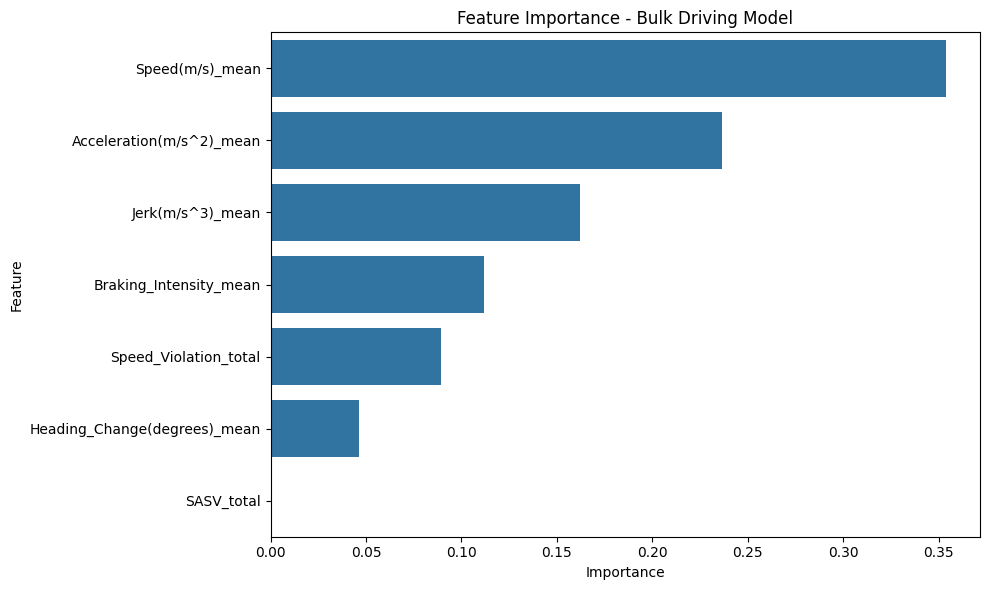

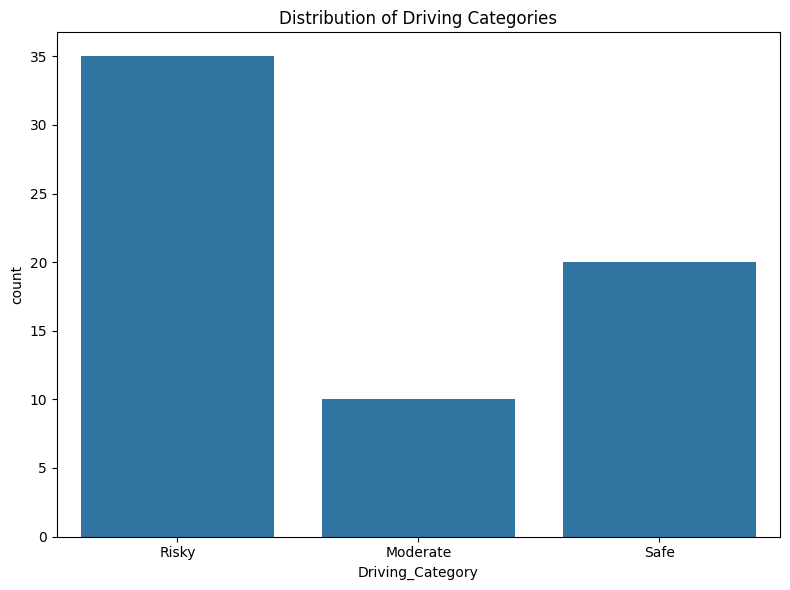

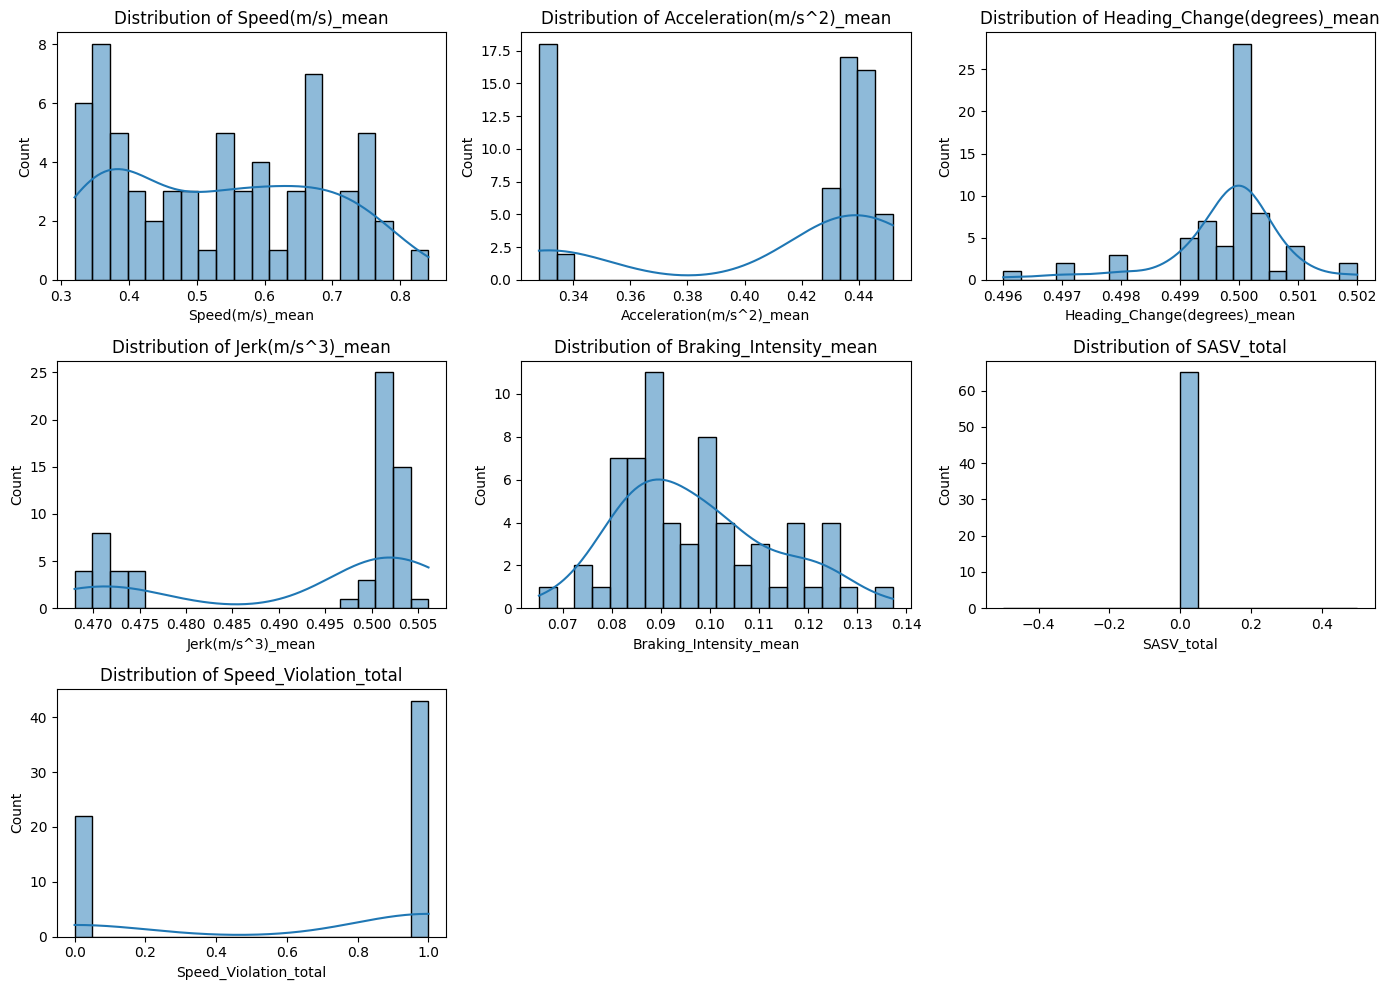

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the aggregated driver-level data with Driving Category
aggregated_data_path = '../data/driver_aggregated_data_with_category.csv'
driver_aggregated_data = pd.read_csv(aggregated_data_path)

# ---------- Model Training ---------- #
# Select features for training
X = driver_aggregated_data[['Speed(m/s)_mean', 'Acceleration(m/s^2)_mean', 'Heading_Change(degrees)_mean',
                            'Jerk(m/s^3)_mean', 'Braking_Intensity_mean', 'SASV_total', 'Speed_Violation_total']]

# Define target variable (Driving_Category)
y = driver_aggregated_data['Driving_Category'].map({'Risky': 0, 'Moderate': 1, 'Safe': 2})

# Handle class imbalance using SMOTE (Optional)
# Uncomment the following lines to apply SMOTE
# smote = SMOTE(random_state=42)
# X, y = smote.fit_resample(X, y)

# Split the dataset into training and testing sets with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
scaler_path = '../models/bulk_scaler.pkl'
with open(scaler_path, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Compute class weights to handle imbalanced classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model with class weights
rf = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)
rf.fit(X_train_scaled, y_train)

# Save the trained model
model_path = '../models/bulk_driving_model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump(rf, model_file)

print("Bulk driving behavior model trained and saved.")

# ---------- Model Evaluation ---------- #

# Predict the test set results
y_pred = rf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'],
            yticklabels=['Risky', 'Moderate', 'Safe'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig('../models/confusion_matrix_bulk_model.png')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Risky', 'Moderate', 'Safe'])
print("Classification Report:")
print(class_report)

# ---------- Cross-Validation ---------- #

# Perform 5-fold cross-validation with stratification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print(f"Cross-Validation Accuracy (5-fold): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# ---------- Feature Importance ---------- #

# Get feature importance from the RandomForest model
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance - Bulk Driving Model")
plt.tight_layout()
plt.savefig('../models/feature_importance_bulk_model.png')
plt.show()

# ---------- Additional Graphs ---------- #

# Driving Category Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Driving_Category', data=driver_aggregated_data, order=['Risky', 'Moderate', 'Safe'])
plt.title("Distribution of Driving Categories")
plt.tight_layout()
plt.savefig('../models/driving_category_distribution.png')
plt.show()

# Histograms of Features
numeric_columns = X.columns

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(driver_aggregated_data[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('../models/bulk_feature_histograms.png')
plt.show()
